In [ ]:
!sudo apt-get install swig

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 24 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 2s (739 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
de

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install box2d-py==2.3.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp310-cp310-linux_x86_64.whl size=2349116 sha256=464d54c7d7e053a0ea8b2ed597b585112fd53118181d4c6826b5c8a71360994f
  Stored in directory: /root/.cache/pip/wheels/47/01/d2/6a780da77ccb98b1d2facdd520a8d10838a03b590f6f8d50c0
Successfully built box2d-py


In [ ]:
pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from tqdm import trange
import gym
import matplotlib.pyplot as plt
from tqdm import trange
import torch.optim as optim
import numpy as np
import torch.nn.utils as nn_utils

In [ ]:
clipping_value = 1
L = 30000         #buffer size
epsilon_max = 0.99
epsilon_min = 0.05
episode = 200
N = 64           #batch size
C = int(L/N)
gamma = 0.99       #discount factor
l_rate = 0.0005      #learning rate for Adam

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class Agent(object):
    ''' Base agent class, used as a parent class

        Args:
            n_actions (int): number of actions

        Attributes:
            n_actions (int): where we store the number of actions
            last_action (int): last action taken by the agent
    '''
    def __init__(self, n_actions: int):
        self.n_actions = n_actions
        self.last_action = None

    def forward(self, state: np.ndarray):
        ''' Performs a forward computation '''
        pass

    def backward(self):
        ''' Performs a backward pass on the network '''
        pass

class RandomAgent(Agent):
    ''' Agent taking actions uniformly at random, child of the class Agent'''
    def __init__(self, n_actions: int):
        super(RandomAgent, self).__init__(n_actions)

    def forward(self, state: np.ndarray) -> int:
        ''' Compute an action uniformly at random across n_actions possible
            choices

            Returns:
                action (int): the random action
        '''
        self.last_action = np.random.randint(0, self.n_actions)
        return self.last_action


class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.tensor(x, device=device, dtype=torch.float32)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [ ]:
env = gym.make('LunarLander-v2')
buffer = []
agent = RandomAgent(env.action_space.n)


#LL = trange(L, desc='Experience: ', leave=True)
while len(buffer) < L:
  i = 0
  done = False
  while done == False:
    if i == 0:
      state = env.reset()
      action = agent.forward(state)
      next_state, reward, done, _ = env.step(action)
      buffer.append((state, action, reward, next_state, done))
      state = next_state
      i = i + 1
    else:
      action = agent.forward(state)
      next_state, reward, done, _ = env.step(action)
      buffer.append((state, action, reward, next_state, done))
      state = next_state
      i = i + 1

buffer = buffer[:L]

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
device = torch.device("cuda")


Z = int(episode*0.9)
# Linearly decay epsilon over Z episodes
def linear_decay(current_episode):
    return max(epsilon_min, epsilon_max - (epsilon_max - epsilon_min) * (current_episode - 1) / (Z - 1))

targetnet = QNetwork(8,env.action_space.n).to(device)
qnet = QNetwork(8,env.action_space.n).to(device)
optimizer = optim.Adam(qnet.parameters(), lr=l_rate)

j = 0
episode_reward_list = []
episode_number_of_steps = []
EPISODES = trange(episode, desc='Episode: ', leave=True)
for i in EPISODES:
  epsilon = linear_decay(i + 1)
  state = env.reset()
  state = torch.tensor(state, device=device, dtype=torch.float32)
  done = False
  total_episode_reward = 0.
  t = 0
  while done == False:
    if np.random.binomial(1,1-epsilon)==1:

      action = torch.argmax(qnet.forward(state)).item()

    else:
      action = agent.forward(state)

    next_state, reward, done, _ = env.step(action)
    buffer.append((state, action, reward, next_state, done))
    buffer = buffer[1:L+1]
    batchind = np.random.randint(len(buffer), size=N).astype(int)
    sample = [buffer[i] for i in batchind]


    sample_states = torch.stack([torch.tensor(exp[0], device=device, dtype=torch.float32) for exp in sample])
    sample_actions = torch.tensor([exp[1] for exp in sample], device=device)
    sample_rewards = torch.tensor([exp[2] for exp in sample], device=device)
    sample_next_states = torch.stack([torch.tensor(exp[3], device=device, dtype=torch.float32) for exp in sample])
    sample_dones = torch.tensor([exp[4] for exp in sample], device=device)
    sample = (sample_states, sample_actions, sample_rewards, sample_next_states, sample_dones)

    qmax_next_states = torch.max(targetnet.forward(sample_next_states), dim=1).values

    q_values = qnet.forward(sample_states).gather(1, sample_actions.unsqueeze(1))

    targets = sample_rewards.float() + gamma * (1 - sample_dones.float()) * qmax_next_states

    loss = torch.nn.functional.mse_loss(q_values, targets.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    nn_utils.clip_grad_norm_(qnet.parameters(), clipping_value)
    optimizer.step()


    state = next_state
    state = torch.tensor(state, device=device, dtype=torch.float32)
    total_episode_reward += reward
    j = j + 1
    t = t + 1
    if j % C == 0:
      targetnet.load_state_dict(qnet.state_dict())
  episode_reward_list.append(total_episode_reward)
  episode_number_of_steps.append(t)

  EPISODES.set_description(f"Episode {i}/{episode} - Avg. Loss: {loss:.4f}")


Episode:   0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-6-f7548bded073>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, device=device, dtype=torch.float32)
<ipython-input-8-6dab7dcb6dd1>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_states = torch.stack([torch.tensor(exp[0], device=device, dtype=torch.float32) for exp in sample])
Episode 199/200 - Avg. Loss: 103.3910: 100%|██████████| 200/200 [09:26<00:00,  2.83s/it]


In [ ]:
len(episode_reward_list), episode

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(200, 200)

In [ ]:
# Save the model
torch.save(targetnet, '/content/drive/MyDrive/RL/neural-network-1.pth')

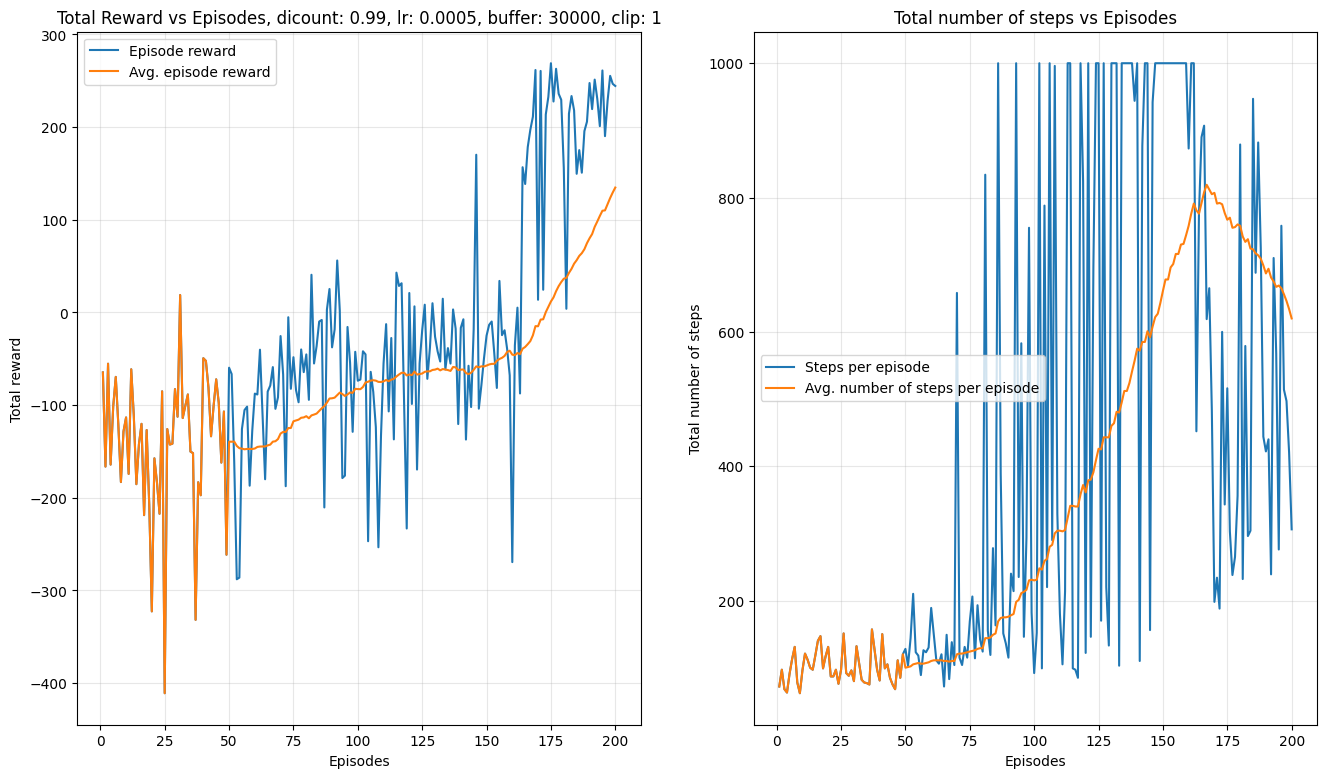

In [ ]:
def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

n_ep_running_average = 50
# Plot Rewards and steps
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
ax[0].plot([i for i in range(1, episode+1)], episode_reward_list, label='Episode reward')
ax[0].plot([i for i in range(1, episode+1)], running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title(f'Total Reward vs Episodes, dicount: {gamma}, lr: {l_rate}, buffer: {L}, clip: {clipping_value}')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1, episode+1)], episode_number_of_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, episode+1)], running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title(f'Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.show()

In [ ]:
# Copyright [2020] [KTH Royal Institute of Technology] Licensed under the
# Educational Community License, Version 2.0 (the "License"); you may
# not use this file except in compliance with the License. You may
# obtain a copy of the License at http://www.osedu.org/licenses/ECL-2.0
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an "AS IS"
# BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express
# or implied. See the License for the specific language governing
# permissions and limitations under the License.
#
# Course: EL2805 - Reinforcement Learning - Lab 2 Problem 1
# Code author: [Alessio Russo - alessior@kth.se]
# Last update: 6th October 2020, by alessior@kth.se
#

# Load packages
import numpy as np
import gym
import torch
from tqdm import trange

def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

# Load model
try:
    model = torch.load('/content/drive/MyDrive/RL/neural-network-1.pth')
    print('Network model: {}'.format(model))
except:
    print('File neural-network-1.pth not found!')
    exit(-1)

# Import and initialize Mountain Car Environment
env = gym.make('LunarLander-v2')
env.reset()

# Parameters
N_EPISODES = 50            # Number of episodes to run for trainings
CONFIDENCE_PASS = 50

# Reward
episode_reward_list = []  # Used to store episodes reward

# Simulate episodes
print('Checking solution...')
EPISODES = trange(N_EPISODES, desc='Episode: ', leave=True)
for i in EPISODES:
    EPISODES.set_description("Episode {}".format(i))
    # Reset enviroment data
    done = False
    state = env.reset()
    total_episode_reward = 0.
    while not done:
        # Get next state and reward.  The done variable
        # will be True if you reached the goal position,
        # False otherwise
        q_values = model(torch.tensor([state]))
        _, action = torch.max(q_values, axis=1)
        next_state, reward, done, _ = env.step(action.item())

        # Update episode reward
        total_episode_reward += reward

        # Update state for next iteration
        state = next_state

    # Append episode reward
    episode_reward_list.append(total_episode_reward)

    # Close environment
    env.close()

avg_reward = np.mean(episode_reward_list)
confidence = np.std(episode_reward_list) * 1.96 / np.sqrt(N_EPISODES)


print('Policy achieves an average total reward of {:.1f} +/- {:.1f} with confidence 95%.'.format(
                avg_reward,
                confidence))

if avg_reward - confidence >= CONFIDENCE_PASS:
    print('Your policy passed the test!')
else:
    print("Your policy did not pass the test! The average reward of your policy needs to be greater than {} with 95% confidence".format(CONFIDENCE_PASS))


Network model: QNetwork(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Checking solution...


Episode 0:   0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-6-f7548bded073>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, device=device, dtype=torch.float32)
Episode 49: 100%|██████████| 50/50 [00:20<00:00,  2.46it/s]

Policy achieves an average total reward of 206.3 +/- 22.9 with confidence 95%.
Your policy passed the test!
